<a href="https://colab.research.google.com/github/mauricef/mauricef.github.io/blob/main/jax-ml/growing-ca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Mon Jan  9 18:05:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    55W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%pip install -q \
    dm_haiku==0.0.9 \
    moviepy==1.0.3 \
    optax==0.1.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 KB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 12.8 MB/s eta 0:00:00


In [4]:
from functools import partial
import hashlib
import io
import json
import os
import pickle
import sys
from tempfile import NamedTemporaryFile
import time
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import haiku as hk
import jax
from jax import jit, lax, vmap, nn, grad
import jax.numpy as jnp
from jax import random
from jax.scipy.signal import convolve2d
import matplotlib.pyplot as plt
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
import numpy as np
import optax
import PIL.Image as Image
import requests

rng = random.PRNGKey(42)

## NCA Model

In [5]:
@jit
def convolve_state_grid(state_grid, filter):
    def _convolve_channel_grid(channel_grid):
        return convolve2d(channel_grid, filter, mode='same')
    return vmap(_convolve_channel_grid, in_axes=-1, out_axes=-1)(state_grid)


@jit
def perceive(state_grid):
    sobel_x = jnp.array([
        [-1, 0, +1],
        [-2, 0, +2],
        [-1, 0, +1]
    ])
    sobel_y = sobel_x.T
    dx = convolve_state_grid(state_grid, sobel_x)
    dy = convolve_state_grid(state_grid, sobel_y)
    perception_grid = jnp.concatenate([state_grid, dx, dy], axis=-1)
    return perception_grid

@jit
def stochastic_update(rng, update_grid, update_pct):
    update_mask = random.uniform(rng, update_grid.shape[:-1])
    update_mask = update_mask < update_pct
    update_mask = jnp.expand_dims(update_mask, -1)
    update_grid *= update_mask
    return update_grid

@jit
def alive_mask(state_grid, alive_threshold):
    alive_grid = hk.max_pool(state_grid[:, :, 0], window_shape=(3, 3), strides=1, padding='SAME')
    alive_grid = alive_grid > alive_threshold
    alive_grid = jnp.expand_dims(alive_grid, -1)
    return alive_grid

def NCA(mlp_hidden, channels, update_pct, alive_threshold, layer1_w_init_zero=True):
    @hk.transform
    def model(state_grid):
        layer1_w_init = hk.initializers.Constant(0.) if layer1_w_init_zero else None
        sequential = hk.Sequential([
            hk.Linear(output_size=mlp_hidden),
            nn.relu,
            hk.Linear(output_size=channels, w_init=layer1_w_init)
        ])
        perception_grid = perceive(state_grid)
        update_grid = vmap(vmap(sequential))(perception_grid)
        rng = hk.next_rng_key()
        update_grid = stochastic_update(rng, update_grid, update_pct) 
        alive_grid = alive_mask(state_grid, alive_threshold)
        state_grid += update_grid
        state_grid *= alive_grid
        return state_grid
    return model

## Training

In [6]:
@partial(jit, static_argnames=('scale'))
def zoom(img, scale=4):
    img = jnp.repeat(img, scale, 0)
    img = jnp.repeat(img, scale, 1)
    return img

def render_video(frames, frames_per_second, output_path):
    frame_count = frames.shape[0]
    frame_size = frames.shape[1]
    frame_shape = (frame_size,) * 2
    with FFMPEG_VideoWriter(size=frame_shape, fps=frames_per_second, filename=output_path) as writer:
        for fr in range(frame_count):
            frame = frames[fr]
            writer.write_frame(frame)

def download_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    response = requests.get(f'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u{code}.png?raw=true')
    response.raise_for_status()
    img_bytes = response.content
    img = Image.open(io.BytesIO(img_bytes))
    img_array = np.array(img)
    return img_array

@partial(jit, static_argnums=(0, 1, 2))
def init_state_grid(height, width, channels):
    x = jnp.zeros(shape=(height, width, channels))
    x = x.at[height//2, width//2, :].set(1.)
    return x

@jit
def premultiply_alpha(img):
    return img[..., :3] * jnp.expand_dims(img[..., 3], -1)

@jit
def to_rgb(state_grid):
    rgb = jnp.clip(state_grid, 0., 1.)
    rgb *= 255.
    rgb = jnp.uint8(rgb)
    return rgb

@jit
def image_loss(state_grid, target_image):
    y = target_image
    yp = state_grid[..., 0]
    return jnp.mean(optax.l2_loss(y, yp))

@partial(jit, static_argnames=('model', 'simulation_steps', 'return_steps'))
def simulate(rng, model, state_grid, update_weights, simulation_steps, return_steps):
    def step(state_grid, rng):
        next_state_grid = model.apply(update_weights, rng, state_grid)
        return next_state_grid, state_grid
    rngs = jnp.array(random.split(rng, simulation_steps))
    final_state_grid, state_grid_steps = lax.scan(step, state_grid, xs=rngs)
    if return_steps:
        all_state_grid_steps = jnp.append(
            state_grid_steps, 
            jnp.expand_dims(final_state_grid, 0),
            axis=0)
        return final_state_grid, state_grid_steps
    else:
        return final_state_grid

@jit
def normalize(a, eps=1e-9):
    norm = jnp.linalg.norm(a)
    return a / (norm + eps)

@partial(jit, static_argnames=('model', 'simulation_steps'))
def batch_simulate(rng, model, state_grid_batch, update_weights, simulation_steps):
    rngs = jnp.array(random.split(rng, batch_size))
    def _simulate(i):
        return simulate(
            rng=rngs[i], 
            model=model,
            state_grid=state_grid_batch[i], 
            update_weights=update_weights, 
            simulation_steps=simulation_steps,
            return_steps=False)
    return vmap(_simulate)(jnp.arange(batch_size))

@partial(jit, static_argnames=('model', 'simulation_steps'))
@partial(grad, has_aux=True)
def grads_and_updated_state_grid_batch(update_weights, rng, state_grid_batch, model, simulation_steps, target_image):
    print('compile')
    updated_state_grid_batch = batch_simulate(
        rng=rng, 
        state_grid_batch=state_grid_batch, 
        model=nca, 
        update_weights=update_weights,
        simulation_steps=simulation_steps)
    def _loss(state_grid):
        return image_loss(state_grid, target_image)
    losses = vmap(_loss)(updated_state_grid_batch)
    loss = jnp.mean(losses)
    return loss, (loss, updated_state_grid_batch)

def display_simulation(state_grid_steps, target_image):
    frames = state_grid_steps[..., 0]
    frames = to_rgb(frames)
    frames = jnp.expand_dims(frames, -1)
    frames = jnp.repeat(frames, repeats=3, axis=-1)
    frames = vmap(lambda frame: frame.at[..., 1].set(to_rgb(target_image)))(frames)
    frames = vmap(lambda frame: zoom(frame, scale=8))(frames)
    video_file = NamedTemporaryFile(suffix='.mp4')
    render_video(frames, frames_per_second=4, output_path=video_file.name)
    display(mvp.ipython_display(video_file.name))

def display_target_image(target_image):
    return PIL.Image.fromarray(np.array(zoom(to_rgb(target_image), scale=8)))

@jit
def manhattan_distance(p1, p2):
    return jnp.abs(p1[0] - p2[0]) + jnp.abs(p1[1] - p2[1])

@partial(jit, static_argnames=('size'))
def manhattan_distance_grid(center, size):
    indicies = jnp.moveaxis(jnp.indices((size, size)), source=0, destination=-1).reshape((-1, 2))
    distances = vmap(lambda i: manhattan_distance(center, i))(indicies)
    distances = jnp.reshape(distances, (size, size))
    return distances

@partial(jit, static_argnames=('size'))
def generate_diamond(size, radius):
    x = manhattan_distance_grid(center=(size//2, size//2), size=size)
    x = jnp.float32(x < radius)
    return x

@partial(jit, static_argnames=('batch_size'))
def sample_pool(rng, pool, batch_size):
    sample_idx = random.choice(rng, pool.shape[0], (batch_size,), replace=False)
    batch = pool[sample_idx]
    return sample_idx, batch

@partial(jit, static_argnames=('pool_reinit_size'))
def update_pool(rng, pool, pool_updates, pool_updates_idx, pool_reinit_size, pool_init):
    rng, r = random.split(rng)
    pool_init_idx = random.choice(r, pool.shape[0], (pool_reinit_size,), replace=False)
    pool = pool.at[pool_updates_idx].set(pool_updates)
    pool = pool.at[pool_init_idx].set(pool_init)
    return pool

@partial(jit, static_argnames=('optimizer'))
def update(grads, update_weights, optimizer, optimizer_state):
    grads = jax.tree_map(normalize, grads)
    updates, optimizer_state = optimizer.update(grads, optimizer_state, update_weights)
    update_weights = optax.apply_updates(updates, update_weights)
    return update_weights, optimizer_state

In [7]:
emoji = "♥"
emoji = download_emoji(emoji)
target_image = emoji[..., 3]
target_image = Image.fromarray(target_image)
target_image.thumbnail((32, 32))
target_image = np.array(target_image)
target_image = np.float32(np.clip(0., 1., target_image/255))
height, width = target_image.shape[0], target_image.shape[1]
channels = 32
hidden_channels = 128
batch_size = 8
pool_size = 64
simulation_steps = 32
pool_reinit_size = 1
layer1_w_init_zero = True
nca = NCA(
    layer1_w_init_zero=layer1_w_init_zero,
    mlp_hidden=hidden_channels, 
    update_pct=.5,
    channels=channels,
    alive_threshold=.1
)
learning_rate = 1e-3
initial_state_grid = init_state_grid(height, width, channels)
rng, r = random.split(rng)
update_weights = nca.init(r, initial_state_grid)
optimizer = optax.adam(learning_rate=learning_rate)
optimizer_state = optimizer.init(update_weights)
state_grid_pool = jnp.repeat(jnp.expand_dims(initial_state_grid, 0), pool_size, axis=0)
losses = []

In [12]:
start = time.time()
for i in range(1, 10_000):
    if i % 500 == 0:
        rng, r = random.split(rng)
        final_state_grid = simulate(
            rng=r, 
            model=nca, 
            state_grid=initial_state_grid, 
            update_weights=update_weights, 
            simulation_steps=128,
            return_steps=False)
        loss = image_loss(final_state_grid, target_image)
        print(i, loss, time.time() - start)
        start = time.time()
    
    rng, r = random.split(rng)
    state_grid_batch_i, state_grid_batch = sample_pool(r, state_grid_pool, batch_size=batch_size)
    rng, r = random.split(rng)
    grads, (loss, updated_state_grid_batch) = grads_and_updated_state_grid_batch(
        update_weights, 
        rng=r, 
        state_grid_batch=state_grid_batch, 
        model=nca, 
        simulation_steps=simulation_steps, 
        target_image=target_image)
    losses.append(loss)
    rng, r = random.split(rng)
    state_grid_pool = update_pool(
        rng=r,
        pool=state_grid_pool,
        pool_updates=updated_state_grid_batch,
        pool_updates_idx=state_grid_batch_i,
        pool_reinit_size=pool_reinit_size,
        pool_init=initial_state_grid
    )
    update_weights, optimizer_state = update(
        grads=grads, 
        update_weights=update_weights, 
        optimizer=optimizer, 
        optimizer_state=optimizer_state)

500 0.032287084 4.956733465194702
1000 0.012848981 4.902171611785889
1500 0.006026519 4.881453037261963
2000 0.004757544 4.887971639633179
2500 0.008419915 4.876449823379517
3000 0.0071788277 4.884044408798218
3500 0.0020591908 4.888613224029541
4000 0.003043303 4.897636890411377
4500 0.0056821513 4.886888027191162
5000 0.01145497 4.893040418624878
5500 0.008810077 4.897293567657471
6000 0.0072599957 4.894414901733398
6500 0.004113801 4.884939670562744
7000 0.0043856725 4.897599458694458
7500 0.0043638153 4.898814916610718
8000 0.0012567558 4.888339519500732
8500 0.0065689376 4.8916404247283936
9000 0.001998934 4.890454530715942
9500 0.008861136 4.878925085067749


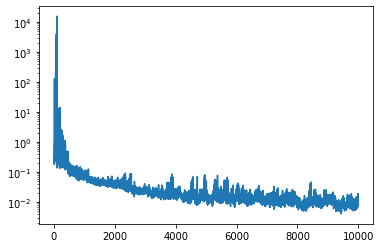

In [9]:
 plt.yscale('log') 
plt.plot(losses)

In [11]:
rng, r = random.split(rng)
final_state_grid, state_grid_steps = simulate(
            rng=r, 
            model=nca, 
            state_grid=initial_state_grid,
            update_weights=update_weights, 
            simulation_steps=128,
            return_steps=True)
display_simulation(state_grid_steps, target_image)